# One-Sided Frequentist Upper Limit With Bands

*Author: Kyle Cranmer.
Contributions from Haichen Wang and Daniel Whiteson. 
Date: Dec. 2010 - Feb. 2011.
Translated to notebook by Enric Tejedor and Danilo Piparo, 2015
v1. Jan 28*

This is a standard demo that can be used with any ROOT file prepared in the standard way. You need to specify:
- Name for input ROOT file.
- Name of workspace inside ROOT file that holds model and data.
- Name of ModelConfig that specifies details for calculator tools.
- Name of dataset.

With default parameters the macro will attempt to run the standard hist2workspace example and read the ROOT file that it produces.

The first ~100 lines define a new test statistic, then the main code starts. You may want to control:
- `double confidenceLevel = 0.95;`
- `int nPointsToScan = 30;`
- `int nToyMC = 200;`

This uses a modified version of the profile likelihood ratio as a test statistic for upper limits (eg. test stat = 0 if muhat>mu).

Based on the observed data, one defines a set of parameter points to be tested based on the value of the parameter of interest and the conditional MLE (eg. profiled) values of the nuisance parameters.

At each parameter point, pseudo-experiments are generated using this fixed reference model and then the test statistic is evaluated. Note, the nuisance parameters are floating in the fits. For each point, the threshold that defines the 95% acceptance region is found. This forms a "Confidence Belt".

After constructing the confidence belt, one can find the confidence interval for any particular dataset by finding the intersection of the observed test statistic and the confidence belt. First this is done on the observed data to get an observed 1-sided upper limit.

Finally, the expected limit and bands (from background-only) are formed by generating background-only data and finding the upper limit. This is done by hand for now, it will later be part of the RooStats tools.

On a technical note, this technique is NOT the Feldman-Cousins technique, because that is a 2-sided interval BY DEFINITION. However, like the Feldman-Cousins technique this is a Neyman-Construction. For technical reasons the easiest way to implement this right now is to use the FeldmanCousins tool and then change the test statistic that it is using.

Building the confidence belt can be computationally expensive. Once it is built, one could save it to a file and use it in a separate step.

We can use PROOF to speed things along in parallel; however, the test statistic has to be installed on the workers so either turn off PROOF or include the modified test statistic in your `$ROOTSYS/roofit/roostats/inc` directory,
add the additional line to the `LinkDef.h` file, and recompile ROOT.

Note, if you have a boundary on the parameter of interest (e.g. cross-section) the threshold on the one-sided test statistic starts off very small because we are only including downward fluctuations.  You can see the threshold in these printouts:

`[#0] PROGRESS:Generation -- generated toys: 500 / 999
NeymanConstruction: Prog: 12/50 total MC = 39 this test stat = 0
 SigXsecOverSM=0.69 alpha_syst1=0.136515 alpha_syst3=0.425415 beta_syst2=1.08496 [-1e+30, 0.011215]in interval = 1`

This tells you the values of the parameters geing used to generate the pseudo-experiments and the threshold in this case is 0.011215.  One would expect for 95% that the threshold would be ~1.35 once the cross-section is far enough away from 0 that it is essentially unaffected by the boundary. As one reaches the last points in the scan, the threshold starts to get artificially high. This is because the range of the parameter in the fit is the same as the range in the scan.  In the future, these should be independently controlled, but they are not now. As a result, ~50% of pseudo-experiments that have an upward fluctuation end up with muhat = muMax.  Because of this, the upper range of the parameter should be well above the expected upper limit, but not too high or one will need a very large value of `nPointsToScan` to resolve the relevant region. This can be improved, but this is the first version of this script.

**Important note**: when the model includes external constraint terms, like a Gaussian constraint to a nuisance parameter centered around some nominal value there is a subtlety. The asymptotic results are all based on the assumption that all the measurements fluctuate, including the nominal values from auxiliary measurements. If these do not fluctuate, this corresponds to an "conditional ensemble". The result is that the distribution of the test statistic can become very non-chi^2. This results in thresholds that become very large. This can be seen in the following thought experiment. Say the model is:

$$Pois(N | s + b) * G(b0|b,sigma)$$

where $G(b0|b,sigma)$ is the external constraint and `b0` is 100. If `N` is also 100 then the profiled value of `b` given `s` is going to be some trade off betwen 100-`s` and `b0`. If `sigma` is `sqrt(N)`, then the profiled value of `b` is probably 100 - `s`/2.  So for `s`=60 we are going to have a profiled value of `b`~70. Now when we generate pseudo-experiments for `s`=60, `b`=70 we will have `N`~130 and the average shat will be 30, not 60. In practice, this is only an issue for values of `s` that are very excluded. For values of `s` near the 95% limit this should not be a big effect. This can be avoided if the nominal values of the constraints also fluctuate, but that requires that those parameters are RooRealVars in the model. This version does not deal with this issue, but it will be addressed in a future version.

---

In [1]:
#include "RooWorkspace.h"
#include "RooSimultaneous.h"
#include "RooAbsData.h"

#include "RooStats/ModelConfig.h"
#include "RooStats/FeldmanCousins.h"
#include "RooStats/ToyMCSampler.h"
#include "RooStats/PointSetInterval.h"
#include "RooStats/ConfidenceBelt.h"

#include "RooStats/RooStatsUtils.h"
#include "RooStats/ProfileLikelihoodTestStat.h"

using namespace RooFit;
using namespace RooStats;


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
auto confidenceLevel = 0.68;
auto nPointsToScan = 20;
auto nToyMC = 80; // This number is kept low to have a quick calculation

In [3]:
auto filename = "results/example_combined_GaussExample_model.root";
auto workspaceName = "combined";
auto modelConfigName = "ModelConfig";
auto dataName = "obsData";

Create an example file.
The `prepareHistFactory` and `hist2workspace` scripts are in `$ROOTSYS/bin`, which is in `$PATH`.

In [4]:
.! prepareHistFactory . >& prepareHistFactory.log

In [5]:
.! hist2workspace config/example.xml >& hist2Workspace.log

Open the example file.

In [6]:
auto file = TFile::Open(filename);

Get the workspace from the file.

In [7]:
auto w = (RooWorkspace*) file->Get(workspaceName);
if (!w) {
    cout << "Workspace not found" << endl;
}

Get the model configuration from the file.

In [8]:
auto mc = (ModelConfig*) w->obj(modelConfigName);
if (!mc) {
    w->Print();
    cout << "ModelConfig was not found" << endl;
}

Get the data from the file.

In [9]:
auto data = w->data(dataName);
if (!data) {
    w->Print();
    cout << "Data was not found" << endl;
}

Get the POI. You may want to adjust the range of your POI.

In [10]:
auto firstPOI = (RooRealVar*) mc->GetParametersOfInterest()->first();

Create and use the FeldmanCousins tool to find and plot the 95% confidence interval on the parameter of interest as specified in the model config.

REMEMBER, we will change the test statistic so this is NOT a Feldman-Cousins interval.

In [11]:
FeldmanCousins fc(*data,*mc);
fc.SetConfidenceLevel(confidenceLevel);
fc.SetNBins(nPointsToScan); // set how many points per parameter of interest to scan
fc.CreateConfBelt(true);    // save the information in the belt for plotting

Feldman-Cousins is a unified limit by definition but the tool takes care of a few things for us like which values of the nuisance parameters should be used to generate toys. So let's just change the test statistic and realize this is no longer "Feldman-Cousins" but is a fully frequentist Neyman-Construction.

In [12]:
auto toymcsampler = (ToyMCSampler*) fc.GetTestStatSampler();
ProfileLikelihoodTestStat* testStat = dynamic_cast<ProfileLikelihoodTestStat*>(toymcsampler->GetTestStatistic());
testStat->SetOneSided(true);

FeldmanCousins: ntoys per point = 156
FeldmanCousins: nEvents per toy will fluctuate about  expectation


Since this tool needs to throw toy MC the PDF needs to be extended or the tool needs to know how many entries in a dataset per pseudo experiment. In the 'number counting form' where the entries in the dataset are counts, and not values of discriminating variables, the datasets typically only have one entry and the PDF is not extended.

In [13]:
if (!mc->GetPdf()->canBeExtended()) {
    if (data->numEntries() == 1)
        fc.FluctuateNumDataEntries(false);
    else
        cout << "Not sure what to do about this model" << endl;
}

In [14]:
if (mc->GetGlobalObservables()) {
    cout << "will use global observables for unconditional ensemble" << endl;
    mc->GetGlobalObservables()->Print();
    toymcsampler->SetGlobalObservables(*mc->GetGlobalObservables());
}

will use global observables for unconditional ensemble
RooArgSet:: = (nom_alpha_syst2,nom_alpha_syst3,nom_gamma_stat_channel1_bin_0,nom_gamma_stat_channel1_bin_1)


Now get the interval. This is the most computationally-intensive part.

In [15]:
PointSetInterval* interval = fc.GetInterval();
ConfidenceBelt* belt = fc.GetConfidenceBelt();


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (obs_x_channel1,weightVar,channelCat)
Parameters of Interest:  RooArgSet:: = (SigXsecOverSM)
Nuisance Parameters:     RooArgSet:: = (alpha_syst2,alpha_syst3,gamma_stat_channel1_bin_0,gamma_stat_channel1_bin_1)
Global Observables:      RooArgSet:: = (nom_alpha_syst2,nom_alpha_syst3,nom_gamma_stat_channel1_bin_0,nom_gamma_stat_channel1_bin_1)
PDF:                     RooSimultaneous::simPdf[ indexCat=channelCat channel1=model_channel1 ] = 0.174888

FeldmanCousins: Model has nuisance parameters, will do profile construction
FeldmanCousins: # points to test = 20
lookup index = 0
NeymanConstruction: Prog: 1/20 total MC = 156 this test stat = 0
 SigXsecOverSM=0.075 alpha_syst2=0.656048 alpha_syst3=0.244567 gamma_stat_channel1_bin_0=1.03397 gamma_stat_channel1_bin_1=1.04971 [-1e+30, 0.0463518]  in interval = 1

NeymanConstruction: Prog: 2/20 total MC = 156 this test stat = 0
 SigXsecOverSM=0.225 alpha_syst2=0.

Print out the interval on the first Parameter of Interest.

In [16]:
cout << "\n " << confidenceLevel*100 <<  "% interval on " << firstPOI->GetName() << " is : ["
     << interval->LowerLimit(*firstPOI) << ", "
     << interval->UpperLimit(*firstPOI) << "] "
     << endl;


 68% interval on SigXsecOverSM is : [0.075, 1.275] 


Get observed UL and value of test statistic evaluated there.

In [17]:
RooArgSet tmpPOI(*firstPOI);
double observedUL = interval->UpperLimit(*firstPOI);
firstPOI->setVal(observedUL);
double obsTSatObsUL = fc.GetTestStatSampler()->EvaluateTestStatistic(*data,tmpPOI);

Ask the calculator which points were scanned.

In [18]:
auto parameterScan = (RooDataSet*) fc.GetPointsToScan();
RooArgSet* tmpPoint;

Make a histogram of parameter vs. threshold.

In [19]:
TH1F histOfThresholds("histOfThresholds","",
                      parameterScan->numEntries(),
                      firstPOI->getMin(),
                      firstPOI->getMax());
histOfThresholds.GetXaxis()->SetTitle(firstPOI->GetName());
histOfThresholds.GetYaxis()->SetTitle("Threshold");

Loop through the points that were tested and ask confidence belt what the upper/lower thresholds were. For FeldmanCousins, the lower cut off is always 0.

In [20]:
for (Int_t i=0; i<parameterScan->numEntries(); ++i) {
    tmpPoint = (RooArgSet*) parameterScan->get(i)->clone("temp");
    double arMax = belt->GetAcceptanceRegionMax(*tmpPoint);
    double poiVal = tmpPoint->getRealValue(firstPOI->GetName());
    histOfThresholds.Fill(poiVal,arMax);
}
TCanvas c1("Results","Results",1000,800);
c1.Divide(2);
c1.cd(1);
histOfThresholds.SetMinimum(0);
histOfThresholds.Draw();
c1.cd(2);

Now we generate the expected bands and power-constraint.

First: find parameter point for mu=0, with conditional MLEs for nuisance parameters.

In [21]:
auto nll = mc->GetPdf()->createNLL(*data);
auto profile = nll->createProfile(*mc->GetParametersOfInterest());
firstPOI->setVal(0.);
profile->getVal(); // this will do fit and set nuisance parameters to profiled values
auto poiAndNuisance = new RooArgSet();
if (mc->GetNuisanceParameters())
    poiAndNuisance->add(*mc->GetNuisanceParameters());
poiAndNuisance->add(*mc->GetParametersOfInterest());
w->saveSnapshot("paramsToGenerateData",*poiAndNuisance);
auto paramsToGenerateData = (RooArgSet*) poiAndNuisance->snapshot();
cout << "\nWill use these parameter points to generate pseudo data for bkg only" << endl;
paramsToGenerateData->Print("v");

RooArgSet unconditionalObs;
unconditionalObs.add(*mc->GetObservables());
unconditionalObs.add(*mc->GetGlobalObservables()); // comment this out for the original conditional ensemble

double CLb = 0;
double CLbinclusive = 0;

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization --  Including the following contraint terms in minimization: (lumiConstraint,alpha_syst1Constraint,alpha_syst2Constraint,alpha_syst3Constraint,gamma_stat_channel1_bin_0_constraint,gamma_stat_channel1_bin_1_constraint)
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_obsData_with_constr_Profile[SigXsecOverSM]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_simPdf_obsData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_obsData_with_constr_Profile[SigXsecOverSM]) determining minimum likelihood for current configurations w.r.t all observable
RooAbsTestStatistic::initSimMode: creating slave calculator #0 for state channel1 (2 dataset entries)
[#1] INFO:Fitting -- RooAbsTestStatistic::initSimMode: created 1 slave calculators.
[#1] INFO:Minization

Now we generate background only and find distribution of upper limits.

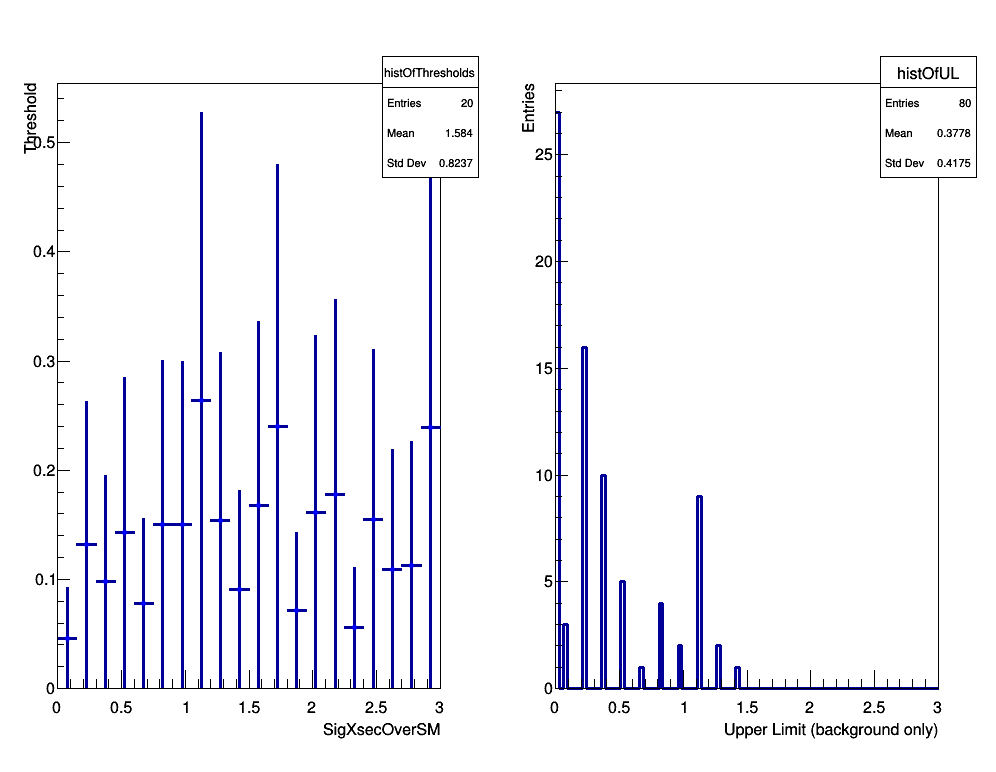

In [22]:
TH1F histOfUL("histOfUL","",100,0,firstPOI->getMax());
histOfUL.GetXaxis()->SetTitle("Upper Limit (background only)");
histOfUL.GetYaxis()->SetTitle("Entries");

for (int imc=0; imc<nToyMC; ++imc) {
    // set parameters back to values for generating pseudo data
    w->loadSnapshot("paramsToGenerateData");
  
    RooDataSet* toyData = 0;
    // now generate a toy dataset
    if(!mc->GetPdf()->canBeExtended()){
        if (data->numEntries() == 1)
            toyData = mc->GetPdf()->generate(*mc->GetObservables(),1);
        else
            cout <<"Not sure what to do about this model" <<endl;
    }
    else {
       toyData = mc->GetPdf()->generate(*mc->GetObservables(),Extended());
    }

    // generate global observables
    // need to be careful for simpdf
    auto simPdf = dynamic_cast<RooSimultaneous*>(mc->GetPdf());
    if (!simPdf) {
        auto one = mc->GetPdf()->generate(*mc->GetGlobalObservables(), 1);
        const RooArgSet *values = one->get();
        auto allVars = mc->GetPdf()->getVariables();
        *allVars = *values;
        delete allVars;
        delete values;
        delete one;
    }
    else {
        //try fix for sim pdf
        auto iter = simPdf->indexCat().typeIterator() ;
        RooCatType* tt = NULL;
        while ((tt=(RooCatType*) iter->Next())) {
            // Get pdf associated with state from simpdf
            auto pdftmp = simPdf->getPdf(tt->GetName()) ;

            // Generate only global variables defined by the pdf associated with this state
            auto globtmp = pdftmp->getObservables(*mc->GetGlobalObservables()) ;
            auto tmp = pdftmp->generate(*globtmp,1) ;

            // Transfer values to output placeholder
            *globtmp = *tmp->get(0) ;

            // Cleanup
            delete globtmp ;
            delete tmp ;
        }
    }
    
    // get test stat at observed UL in observed data
    firstPOI->setVal(observedUL);
    double toyTSatObsUL = fc.GetTestStatSampler()->EvaluateTestStatistic(*toyData,tmpPOI);
    
    if (obsTSatObsUL < toyTSatObsUL) // not sure about <= part yet
        CLb+= (1.)/nToyMC;
    if (obsTSatObsUL <= toyTSatObsUL) // not sure about <= part yet
        CLbinclusive+= (1.)/nToyMC;

    // loop over points in belt to find upper limit for this toy data
    double thisUL = 0;
    for (Int_t i=0; i<parameterScan->numEntries(); ++i) {
        tmpPoint = (RooArgSet*) parameterScan->get(i)->clone("temp");
        double arMax = belt->GetAcceptanceRegionMax(*tmpPoint);
        firstPOI->setVal( tmpPoint->getRealValue(firstPOI->GetName()) );
        double thisTS = fc.GetTestStatSampler()->EvaluateTestStatistic(*toyData,tmpPOI);

        if (thisTS<=arMax) {
            thisUL = firstPOI->getVal();
        }
        else {
            break;
        }
    }
    histOfUL.Fill(thisUL);

    // for few events, data is often the same, and UL is often the same
    delete toyData;
}
histOfUL.Draw();
c1.Draw();

Now find bands and power constraint.

In [23]:
auto bins = histOfUL.GetIntegral();
auto cumulative = (TH1F*) histOfUL.Clone("cumulative");
cumulative->SetContent(bins);
double band2sigDown, band1sigDown, bandMedian, band1sigUp,band2sigUp;

for (int i=1; i<=cumulative->GetNbinsX(); ++i) {
    if(bins[i]<RooStats::SignificanceToPValue(2))
        band2sigDown=cumulative->GetBinCenter(i);
    if(bins[i]<RooStats::SignificanceToPValue(1))
        band1sigDown=cumulative->GetBinCenter(i);
    if(bins[i]<0.5)
        bandMedian=cumulative->GetBinCenter(i);
    if(bins[i]<RooStats::SignificanceToPValue(-1))
        band1sigUp=cumulative->GetBinCenter(i);
    if(bins[i]<RooStats::SignificanceToPValue(-2))
        band2sigUp=cumulative->GetBinCenter(i);
}

cout << "-2 sigma  band " << band2sigDown << endl;
cout << "-1 sigma  band " << band1sigDown << " [Power Constraint)]" << endl;
cout << "median of band " << bandMedian << endl;
cout << "+1 sigma  band " << band1sigUp << endl;
cout << "+2 sigma  band " << band2sigUp << endl;

-2 sigma  band 0
-1 sigma  band 0 [Power Constraint)]
median of band 0.195
+1 sigma  band 0.945
+2 sigma  band 1.245


Print out the interval on the first Parameter of Interest.

In [24]:
cout << "\nobserved " << confidenceLevel*100 <<  "% upper-limit "<< interval->UpperLimit(*firstPOI) <<endl;
cout << "CLb strict [P(toy>obs|0)] for observed " << confidenceLevel*100 <<  "% upper-limit "<< CLb <<endl;
cout << "CLb inclusive [P(toy>=obs|0)] for observed " << confidenceLevel*100 <<  "% upper-limit "<< CLbinclusive <<endl;

delete profile;
delete nll;


observed 68% upper-limit 1.275
CLb strict [P(toy>obs|0)] for observed 68% upper-limit 0.9875
CLb inclusive [P(toy>=obs|0)] for observed 68% upper-limit 0.9875
